# **Обучение модели на физико-химических и топологических признаках + 5 различных наборов данных**

In [ ]:
data = pd.read_csv('data/result_fingerprint_maccs.csv')

In [ ]:
target_col = 'score'


X = data.drop(columns=[target_col])
y = data[target_col]

**Стандартизация фичей**

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd


scaler = StandardScaler()


X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)


print("Средние значения после стандартизации (≈0):")
print(X_scaled.mean().round(3).head())

print("\nСтандартные отклонения после стандартизации (≈1):")
print(X_scaled.std().round(3).head())

Средние значения после стандартизации (≈0):
MW_EXACT   -0.0
XLogP       0.0
HBA        -0.0
HBD        -0.0
TPSA_NO     0.0
dtype: float64

Стандартные отклонения после стандартизации (≈1):
MW_EXACT    1.0
XLogP       1.0
HBA         1.0
HBD         1.0
TPSA_NO     1.0
dtype: float64


**Удаление коррелирующих признаков**

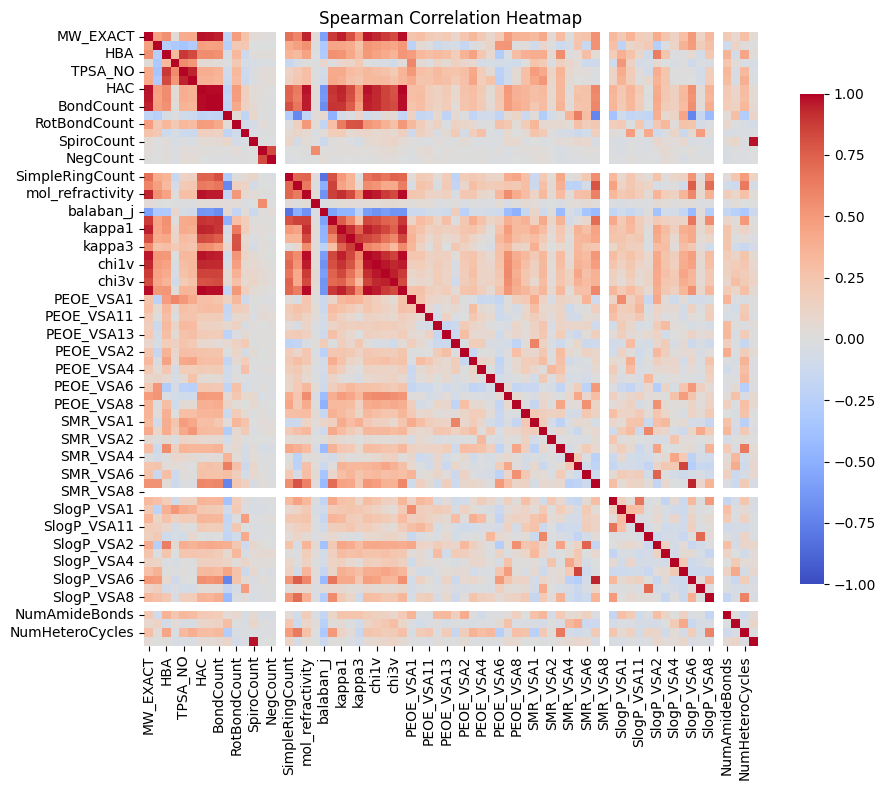

Оставшиеся признаки: ['MW_EXACT', 'XLogP', 'HBA', 'HBD', 'TPSA_NO', 'FSP3', 'RotBondCount', 'HalogenCount', 'SpiroCount', 'PosCount', 'NegCount', 'ComponentCount', 'SimpleRingCount', 'AromaticRingCount', 'formal_charge', 'balaban_j', 'kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'NumAmideBonds', 'NumAlifCarboxy', 'NumHeteroCycles']
Размер до: (89572, 70), после: (89572, 55)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X_spearman = X_scaled.copy()

corr_spearman = X_spearman.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spearman,
    annot=False,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

upper = corr_spearman.where(np.triu(np.ones(corr_spearman.shape), k=1).astype(bool))

# Список признаков с |corr| > 0.9
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.9)]

X_filtered = X_spearman.drop(columns=to_drop)

print("Оставшиеся признаки:", X_filtered.columns.tolist())
print(f"Размер до: {X_spearman.shape}, после: {X_filtered.shape}")

y_filtered = y.loc[X_filtered.index]

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

X = X_filtered
y = y_filtered

def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)

    # 5-фолдовая кросс-валидация по MSE
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model,
        X,
        y,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )
    return -np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Лучшие гиперпараметры:")
print(study.best_params)
print(f"Лучшее значение MSE: {study.best_value:.4f}")


[I 2025-09-23 13:17:37,471] A new study created in memory with name: no-name-782eaa14-38a0-4daf-8d88-41a0ea237abd
[I 2025-09-23 13:20:56,637] Trial 1 finished with value: 36.51810767588829 and parameters: {'iterations': 100, 'learning_rate': 0.021696596725180976, 'depth': 5, 'l2_leaf_reg': 1.2795008305730633, 'random_strength': 2.8232300848682486, 'subsample': 0.6588358952605997, 'min_data_in_leaf': 37}. Best is trial 1 with value: 36.51810767588829.
[I 2025-09-23 13:22:17,925] Trial 0 finished with value: 23.027643915120574 and parameters: {'iterations': 1000, 'learning_rate': 0.10882832209859873, 'depth': 7, 'l2_leaf_reg': 3.9648432647984455, 'random_strength': 9.611855674679747, 'subsample': 0.9913269913407272, 'min_data_in_leaf': 83}. Best is trial 0 with value: 23.027643915120574.
[I 2025-09-23 13:22:44,732] Trial 2 finished with value: 27.21814829145805 and parameters: {'iterations': 300, 'learning_rate': 0.04093954624590371, 'depth': 7, 'l2_leaf_reg': 0.32118924840830726, 'rando

**Обучение RandomForest**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

best_params = {'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}

model = RandomForestRegressor(**best_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

y_array = y.values.ravel()
r2_scores = cross_val_score(model, X, y_array, cv=cv, scoring="r2")

rmse_scores = -cross_val_score(model, X, y_array, cv=cv,
                               scoring="neg_root_mean_squared_error")
# MAE
mae_scores = -cross_val_score(model, X, y_array, cv=cv,
                              scoring="neg_mean_absolute_error")

print("===== Результаты кросс-валидации =====")
print(f"Средний R² : {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"Средний RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
print(f"Средний MAE : {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")



metrics_df = pd.DataFrame({
    "R2":   r2_scores,
    "RMSE": rmse_scores,
    "MAE":  mae_scores
})

plt.figure(figsize=(10, 5))
sns.boxplot(data=metrics_df, palette="pastel")
sns.swarmplot(data=metrics_df, color=".25", size=6)  # точки каждого фолда
plt.title("Кросс-валидация: распределение метрик по фолдам")
plt.ylabel("Значение метрики")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, cv.n_splits + 1), r2_scores, marker='o')
plt.title("R² на каждом фолде")
plt.xlabel("Фолд")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid()
plt.show()

building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.1s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    8.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   11.4s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   14.7s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   18.1s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:   22.1s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   25.4s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:   28.7s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:   32.5s
building tree 10 of 100
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:   35.9s
building tree 11 of 100
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:   39.3s
building tree 12 of 100
[Parallel(n_jobs=1)]: Done  12 tasks      | elapse